# SMS Spam Classifier

## Import libraries 

In [129]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import pickle

## Importing dataset

In [59]:
df = pd.read_csv('../Datasets/spam.csv', encoding='ISO-8859-1')

In [60]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [61]:
df.shape

(5572, 5)

## Data Cleaning 

We can see there are 3 columns with just NaN values. Let's explore these first

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


as majority of values in these 3 columns are NaN, we will be dropping these

In [63]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [64]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [65]:
df.rename(columns = {'v1' : 'target', 'v2' : 'text'}, inplace = True)

In [66]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Next we will encode our targets using LabelEncoder

In [67]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [68]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [69]:
encoder.classes_

array(['ham', 'spam'], dtype=object)

In [70]:
df.isnull().sum()

target    0
text      0
dtype: int64

There are no null values

In [71]:
df.duplicated().sum()

403

There are 403 duplicate values

In [72]:
df = df.drop_duplicates(keep = 'first')

In [73]:
df.duplicated().sum()

0

In [74]:
df.shape

(5169, 2)

## EDA

Let's see how imbalanced our dataset is

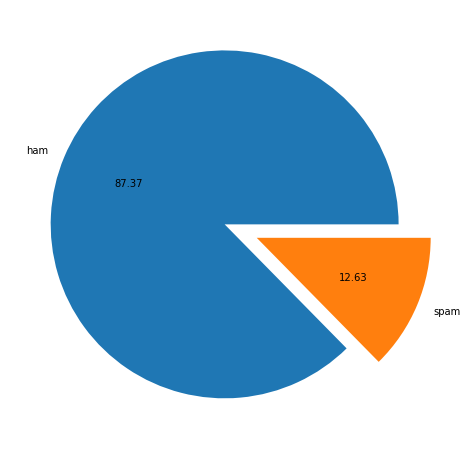

In [75]:
# sns.countplot(df['target']);
figure = plt.figure(figsize = (10,8))
plt.pie(df['target'].value_counts(), labels = encoder.classes_, autopct = "%0.2f", explode = [0, 0.2])
plt.show()

87.37% of our data is ham, whereas only 12.63% of our data is spam

In [76]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x : len(nltk.word_tokenize(x)))
df['num_sent'] = df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))

In [77]:
df.head()

,target,text,num_characters,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


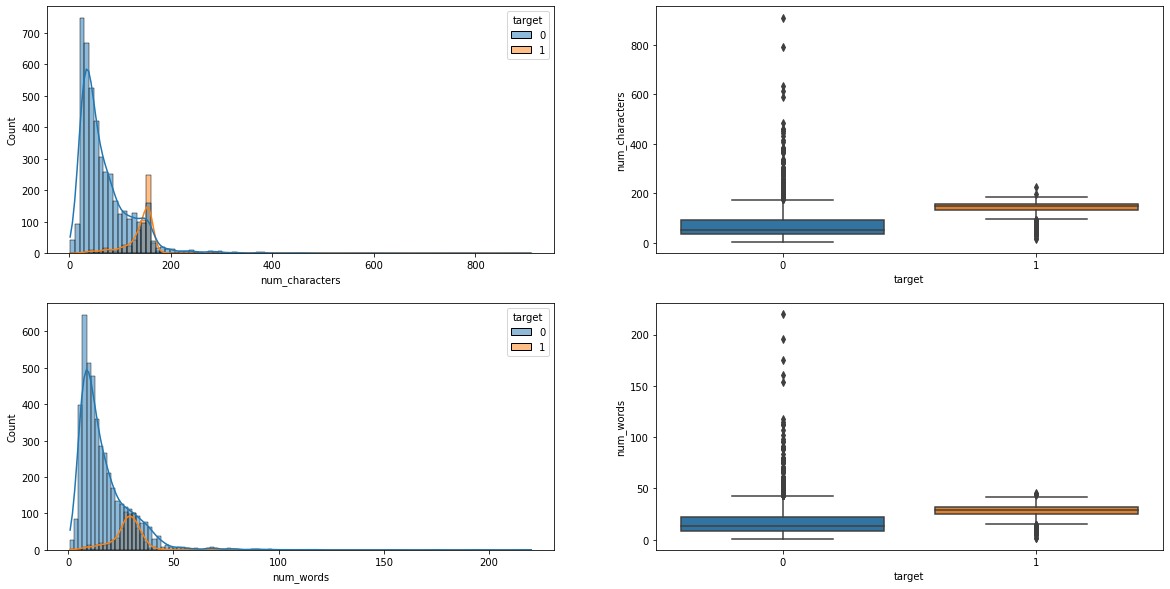

In [78]:
fig, ax = plt.subplots(2, 2, figsize = (20,10))
sns.histplot(df, x = 'num_characters',hue = 'target', kde = True, ax = ax[0,0])
sns.boxplot(x = df['target'], y = df['num_characters'], ax = ax[0,1])
sns.histplot(df, x = 'num_words',hue = 'target', kde = True, ax = ax[1,0])
sns.boxplot(x = df['target'], y = df['num_words'], ax = ax[1,1])
plt.show()

It seems like longer messages have higher chance of being a spam message

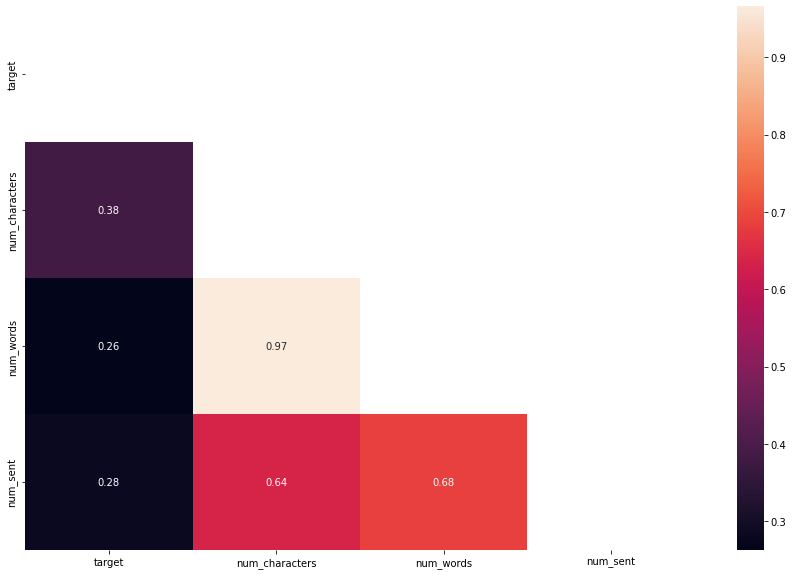

In [79]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr(), annot = True, mask = np.triu(np.ones_like(df.corr())))
plt.show()

There is high correlation among the features, so we will have to remove some features

## Data Preprocessing

<li>Remove lower case
<li>Tokenize
<li>Remove special characters
<li>Remove stop word and punctuation
<li>Stemming

In [80]:
def transform_text(text):
    '''
    This functions performs data preprocessing on text
    
    Parameters :
        text :: str
            string to be transformed
    
    Returns : 
        new_text :: str
            transformed string
    '''
    
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    #Removing special characters
    new_text =  []
    for alpha in text:
        if alpha.isalnum():
            new_text.append(alpha)
    
    text = new_text[:]
    new_text.clear()
    
    #Removing stopwords and punctuations
    for alpha in text:
        if alpha not in stopwords.words('english') and alpha not in string.punctuation:
            new_text.append(alpha)
   
    #Stemming
    ps = PorterStemmer()
    text = new_text[:]
    new_text.clear()
    
    for alpha in text:
        new_text.append(ps.stem(alpha))
    
    new_text = " ".join(new_text)
    return new_text

In [81]:
df['transformed_text'] = df['text'].apply(transform_text)

In [82]:
df.head()

,target,text,num_characters,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


Let's create a word cloud to see the most common words being used in spam and ham messages

In [83]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = " "))

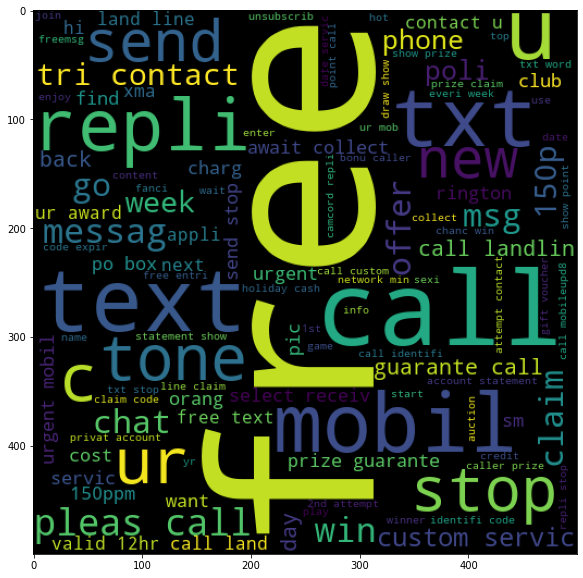

In [84]:
plt.figure(figsize = (15, 10))
plt.imshow(spam_wc)

In [85]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = " "))

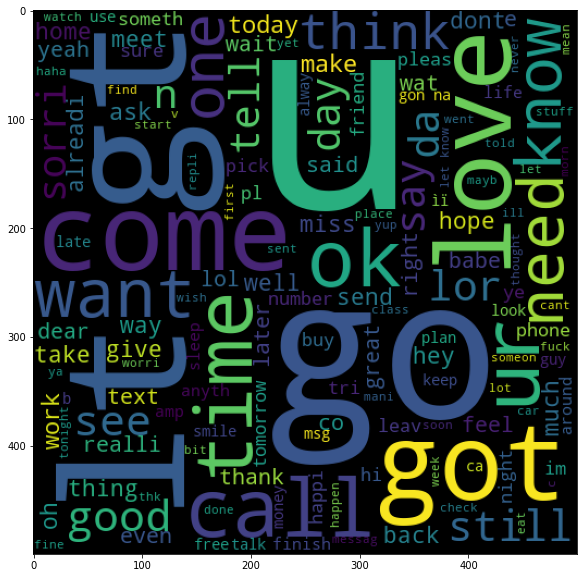

In [86]:
plt.figure(figsize = (15, 10))
plt.imshow(ham_wc)

In [87]:
spam_corpus = []

for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [88]:
len(spam_corpus)

9939

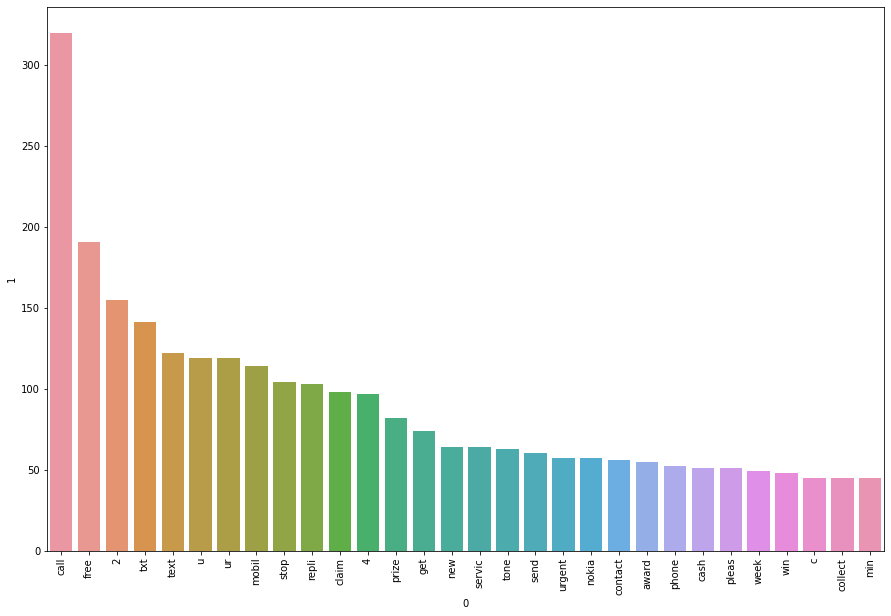

In [89]:
plt.figure(figsize = (15, 10))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

In [90]:
ham_corpus = []

for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [91]:
len(ham_corpus)

35394

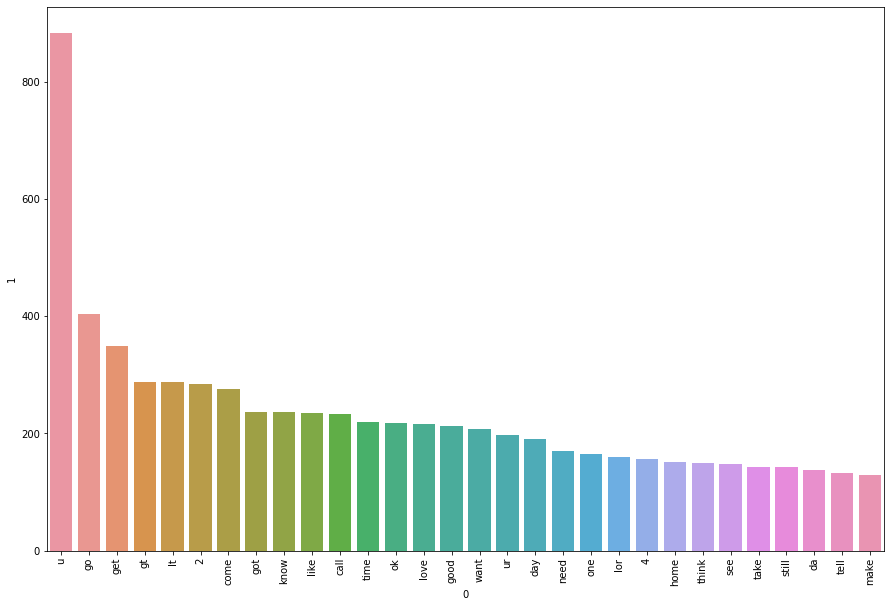

In [92]:
plt.figure(figsize = (15, 10))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

## Model Building

Naive Bayes performs well on textual data so we will be experimenting with it first

In [93]:
cv = CountVectorizer()

In [94]:
X = cv.fit_transform(df['transformed_text']).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [95]:
X.shape

(5169, 6708)

In [96]:
y = df['target'].values

In [97]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [98]:
y.shape

(5169,)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [100]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [101]:
gnb.fit(X_train, y_train)
mnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)

BernoulliNB()

In [102]:
y_pred1 = gnb.predict(X_test)
y_pred2 = mnb.predict(X_test)
y_pred3 = bnb.predict(X_test)

print('Accuracy Score for Gaussian : {}'.format(accuracy_score(y_test, y_pred1)))
print('Confusion Matrix for Gaussian : \n{}'.format(confusion_matrix(y_test, y_pred1)))
print('Precision Score for Gaussian : {}'.format(precision_score(y_test, y_pred1)))

print('\n')

print('Accuracy Score for Multinomial : {}'.format(accuracy_score(y_test, y_pred2)))
print('Confusion Matrix for Multinomial : \n{}'.format(confusion_matrix(y_test, y_pred2)))
print('Precision Score for Multinomial : {}'.format(precision_score(y_test, y_pred2)))

print('\n')

print('Accuracy Score for Bernoulli : {}'.format(accuracy_score(y_test, y_pred3)))
print('Confusion Matrix for Bernoulli : \n{}'.format(confusion_matrix(y_test, y_pred3)))
print('Precision Score for Bernoulli : {}'.format(precision_score(y_test, y_pred3)))

Accuracy Score for Gaussian : 0.8800773694390716
Confusion Matrix for Gaussian : 
[[792 104]
 [ 20 118]]
Precision Score for Gaussian : 0.5315315315315315


Accuracy Score for Multinomial : 0.9642166344294004
Confusion Matrix for Multinomial : 
[[871  25]
 [ 12 126]]
Precision Score for Multinomial : 0.8344370860927153


Accuracy Score for Bernoulli : 0.9700193423597679
Confusion Matrix for Bernoulli : 
[[893   3]
 [ 28 110]]
Precision Score for Bernoulli : 0.9734513274336283


Let us use Tfidf Vectorizer and see the results

In [103]:
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

gnb.fit(X_train, y_train)
mnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)

BernoulliNB()

In [104]:
y_pred1 = gnb.predict(X_test)
y_pred2 = mnb.predict(X_test)
y_pred3 = bnb.predict(X_test)

print('Accuracy Score for Gaussian : {}'.format(accuracy_score(y_test, y_pred1)))
print('Confusion Matrix for Gaussian : \n{}'.format(confusion_matrix(y_test, y_pred1)))
print('Precision Score for Gaussian : {}'.format(precision_score(y_test, y_pred1)))

print('\n')

print('Accuracy Score for Multinomial : {}'.format(accuracy_score(y_test, y_pred2)))
print('Confusion Matrix for Multinomial : \n{}'.format(confusion_matrix(y_test, y_pred2)))
print('Precision Score for Multinomial : {}'.format(precision_score(y_test, y_pred2)))

print('\n')

print('Accuracy Score for Bernoulli : {}'.format(accuracy_score(y_test, y_pred3)))
print('Confusion Matrix for Bernoulli : \n{}'.format(confusion_matrix(y_test, y_pred3)))
print('Precision Score for Bernoulli : {}'.format(precision_score(y_test, y_pred3)))

Accuracy Score for Gaussian : 0.8694390715667312
Confusion Matrix for Gaussian : 
[[788 108]
 [ 27 111]]
Precision Score for Gaussian : 0.5068493150684932


Accuracy Score for Multinomial : 0.9709864603481625
Confusion Matrix for Multinomial : 
[[896   0]
 [ 30 108]]
Precision Score for Multinomial : 1.0


Accuracy Score for Bernoulli : 0.9835589941972921
Confusion Matrix for Bernoulli : 
[[895   1]
 [ 16 122]]
Precision Score for Bernoulli : 0.991869918699187


For now it looks like Tfidf Vectorizer with multinomial naive bayes is our best option since it has the highest precision score. In this use case we want high precision score, because we don't want to ham messages to be misclassified as spam

## Model Selection

In [105]:
svc = SVC(kernel = 'sigmoid', gamma = 0.1)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)
xgb = XGBClassifier(n_estimators = 50, random_state = 2)

In [106]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB' : mnb,
    'DT' : dtc,
    'RF' : rfc,
    'AB' : abc,
    'BgC' : bc,
    'ET' : etc,
    'GBC' : gbdt,
    'XGB' : xgb
}

In [107]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    '''
    This functions trains the classifier and returns the accuracy and precision score
    
    Parameters :
        clf :: 
            The classifier to be trained
        X_train :: 
            Training data
        y_train :: 
            Training labels
        X_test :: 
            Testing data
        y_test ::
            Testing labels
    Returns : 
        accuracy :: 
            Accuracy score of the model
        precision :: 
            Precision score of the model
    '''
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [108]:
accuracy_scores = []
precision_scores = []

for names, clf in clfs.items():
    cur_accuracy, cur_precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    accuracy_scores.append(cur_accuracy)
    precision_scores.append(cur_precision)
    print("{} Completed".format(names))

SVC Completed
KN Completed
NB Completed
DT Completed
RF Completed
AB Completed
BgC Completed
ET Completed
GBC Completed
XGB Completed


In [109]:
performance_df = pd.DataFrame({'Algorithms' : clfs.keys(), 'Accuracy' : accuracy_scores, 'Precision' : precision_scores})

In [116]:
performance_df.sort_values(by = ['Precision', 'Accuracy'], ascending = False)

,Algorithms,Accuracy,Precision
2,NB,0.970986,1.000000
1,KN,0.905222,1.000000
4,RF,0.974855,0.982759
7,ET,0.974855,0.974576
0,SVC,0.929400,0.971014
9,XGB,0.971954,0.943089
5,AB,0.960348,0.929204
8,GBC,0.947776,0.920000
6,BgC,0.957447,0.867188
3,DT,0.932302,0.833333


After comparing different models we see that Naive Bayes performs the best

Let's try some ensemble learning algorithms

In [119]:
#Voting Classifier
svc = SVC(kernel = 'sigmoid', gamma = 0.1, probability = True)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators = 50, random_state = 2)

voting = VotingClassifier(estimators = [('SVM', svc), ('NB', mnb), ('RF', rf)])
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('SVM',
                              SVC(gamma=0.1, kernel='sigmoid',
                                  probability=True)),
                             ('NB', MultinomialNB()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2))])

In [123]:
y_pred = voting.predict(X_test)
print("Accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("Precision : {}".format(precision_score(y_test, y_pred)))

Accuracy : 0.9680851063829787
Precision : 1.0


In [126]:
#Stacking
svc = SVC(kernel = 'sigmoid', gamma = 0.1, probability = True)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators = 50, random_state = 2)
estimators = [('SVM', svc), ('NB', mnb), ('RF', rf)]
final_estimator = ExtraTreesClassifier()

stack = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM',
                                SVC(gamma=0.1, kernel='sigmoid',
                                    probability=True)),
                               ('NB', MultinomialNB()),
                               ('RF',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=2))],
                   final_estimator=ExtraTreesClassifier())

In [127]:
y_pred = stack.predict(X_test)
print("Accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("Precision : {}".format(precision_score(y_test, y_pred)))

Accuracy : 0.9777562862669246
Precision : 0.9457364341085271


Out of all the algorithms tested, Multinomial Naive Bayes performs the best so we will be using that

In [128]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print("Accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("Precision : {}".format(precision_score(y_test, y_pred)))

Accuracy : 0.9709864603481625
Precision : 1.0


In [131]:
pickle.dump(tfidf, open('../Scripts/vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('../Scripts/model.pkl', 'wb'))